# BigData Final Project | Steam
## <font color = 'blue'> Notebook7 | Finising_Visulization </font>
### Team Member: Jim Fang, WooJong Choi, Han Jeon, Tam Nguyen

June 2020
___

### Visuliazation for Finding Slides

---
## I. Import Libraries

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
import pyspark.sql.types as t
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, when, count, col, size
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import length
from pyspark.sql import functions as sf
from pyspark.sql.functions import collect_set, collect_list, array_contains
from pyspark.sql.functions import substring
from functools import reduce

from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.enableHiveSupport().appName('Finiding_Visualization').getOrCreate()
sc = spark.sparkContext

In [3]:
!hdfs dfs -ls /user/tamng/jwht/EDA

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 12 items
drwxr-xr-x   - tamng tamng          0 2020-06-03 11:00 /user/tamng/jwht/EDA/friends.csv
drwxr-xr-x   - tamng tamng          0 2020-06-02 14:42 /user/tamng/jwht/EDA/merge_table.csv
drwxr-xr-x   - tamng tamng          0 2020-06-04 13:41 /user/tamng/jwht/EDA/player_app_cluster.csv
drwxr-xr-x   - tamng tamng          0 2020-06-04 12:14 /user/tamng/jwht/EDA/player_cluster.csv
drwxr-xr-x   - tamng tamng          0 2020-06-02 14:48 /user/tamng/jwht/EDA/player_df1.csv
drwxr-xr-x   - tamng tamng          0 2020-06-02 15:21 /user/tamng/jwht/EDA/player_df2.csv
drwxr-xr-x   - tamng tamng          0 2020-06-03 11:00 /user/tamng/jwht/EDA/player_df3.csv
drwxr-xr-x   - tamng tamng          0 2020-06-03 11:30 /user/tamng/jwht/EDA/player_df4.csv
drwxr-xr-x   - tamng tamng          0 2020-06-03 12:48 /user/tamng/jwht/EDA/player_df5.csv
drwxr-xr-x   - tamng tamng          0 2020-06-03 23:

In [4]:
!hdfs dfs -ls /user/tamng/jwht/Cluster

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 10 items
drwxr-xr-x   - tamng tamng          0 2020-06-05 17:47 /user/tamng/jwht/Cluster/als_df.csv
drwxr-xr-x   - tamng tamng          0 2020-06-04 20:05 /user/tamng/jwht/Cluster/basket_100_df.csv
drwxr-xr-x   - tamng tamng          0 2020-06-04 14:04 /user/tamng/jwht/Cluster/cluster_info.csv
drwxr-xr-x   - tamng tamng          0 2020-06-05 08:14 /user/tamng/jwht/Cluster/recommendation_basket
drwxr-xr-x   - tamng tamng          0 2020-06-04 14:01 /user/tamng/jwht/Cluster/top20games_cluster0.csv
drwxr-xr-x   - tamng tamng          0 2020-06-04 14:01 /user/tamng/jwht/Cluster/top20games_cluster1.csv
drwxr-xr-x   - tamng tamng          0 2020-06-04 14:01 /user/tamng/jwht/Cluster/top20games_cluster2.csv
drwxr-xr-x   - tamng tamng          0 2020-06-04 14:01 /user/tamng/jwht/Cluster/top20games_cluster3.csv
drwxr-xr-x   - tamng tamng          0 2020-06-04 14:02 /user/tamng/jwht/Clust

## III. Import data

### . player_final

In [10]:
player_app_cluster = spark.read.csv('/user/tamng/jwht/EDA/player_app_cluster.csv', inferSchema = True, header = True)

In [11]:
player_app_cluster.limit(2).toPandas()

,steam_id,app_id,playtime_2weeks,playtime_forever,dateretrieved,title,type,price,releaseDate,rating,...,Early Access,Casual,Action,Strategy,Indie,Free to Play,RPG,Simulation,cluster,year
0,76561197960266975,10,0,0,2014-08-14 14:04:54,Counter-Strike,game,9.99,11/1/2000 0:00,88,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4,2000
1,76561197960266975,20,0,0,2014-08-14 14:04:54,Team Fortress Classic,game,4.99,4/1/1999 0:00,-1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4,1999


In [44]:
player_app_cluster.printSchema()

root
 |-- steam_id: long (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- playtime_2weeks: integer (nullable = true)
 |-- playtime_forever: integer (nullable = true)
 |-- dateretrieved: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- releaseDate: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- ageRequirement: integer (nullable = true)
 |-- isMultiplayer: integer (nullable = true)
 |-- positiveReviewPercent: integer (nullable = true)
 |-- Education: double (nullable = true)
 |-- Massively Multiplayer: double (nullable = true)
 |-- Adventure: double (nullable = true)
 |-- Sports: double (nullable = true)
 |-- Accounting: double (nullable = true)
 |-- Audio Production: double (nullable = true)
 |-- Video Production: double (nullable = true)
 |-- Animation & Modeling: double (nullable = true)
 |-- Racing: double (nullable = true)
 |-- Design & Illustration: doubl

### 1. Top 20 most popular games

In [16]:
top20_games = player_app_cluster.groupby('app_id', 'title').count().orderBy('count', ascending = False).limit(20).toPandas()
top20_games

,app_id,title,count
0,10,Counter-Strike,2230515
1,240,Counter-Strike: Source,2056456
2,340,Half-Life 2: Lost Coast,2046927
3,320,Half-Life 2: Deathmatch,2017158
4,220,Half-Life 2,1952951
5,70,Half-Life,1912703
6,50,Half-Life: Opposing Force,1897439
7,130,Half-Life: Blue Shift,1897297
8,20,Team Fortress Classic,1896583
9,30,Day of Defeat,1893058


### 2. The most addicted game: highest average playtime forever by game

In [21]:
top20_addicted_games = player_app_cluster.groupBy('app_id','title').agg(F.avg('playtime_forever').alias('average_playtime'),\
                                                                 F.sum('playtime_forever').alias('total_playtime')).orderBy('average_playtime', ascending = False).limit(20).toPandas()
top20_addicted_games

,app_id,title,average_playtime,total_playtime
0,570,Dota 2,14231.384406,5372859943
1,257650,Mosaico,13234.287879,873463
2,47410,Stronghold Kingdoms,11752.683175,49596323
3,227400,Darkfall Unholy Wars,9181.758140,1974078
4,8500,EVE Online,8155.533912,246019836
5,9900,Star Trek Online,7153.062809,211373006
6,72850,The Elder Scrolls V: Skyrim,6569.102776,2446471825
7,10190,Call of Duty??: Modern Warfare?? 2,6373.777319,1755758943
8,39120,RIFT,6355.684118,294261819
9,440,Team Fortress 2,6308.913472,4134022804


[Text(0,0,'Dota 2'),
 Text(0,0,'Mosaico'),
 Text(0,0,'Stronghold Kingdoms'),
 Text(0,0,'Darkfall Unholy Wars'),
 Text(0,0,'EVE Online'),
 Text(0,0,'Star Trek Online'),
 Text(0,0,'The Elder Scrolls V: Skyrim'),
 Text(0,0,'Call of Duty??: Modern Warfare?? 2'),
 Text(0,0,'RIFT'),
 Text(0,0,'Team Fortress 2'),
 Text(0,0,'Time Rifters'),
 Text(0,0,"Sid Meier's Civilization?? V"),
 Text(0,0,'APB Reloaded'),
 Text(0,0,'Forsaken World'),
 Text(0,0,'Warframe'),
 Text(0,0,'Counter-Strike: Global Offensive'),
 Text(0,0,'Battlefield: Bad Company??? 2'),
 Text(0,0,'PlanetSide 2'),
 Text(0,0,'Dragon Age: Origins'),
 Text(0,0,'Total War???: ROME II - Emperor Edition')]

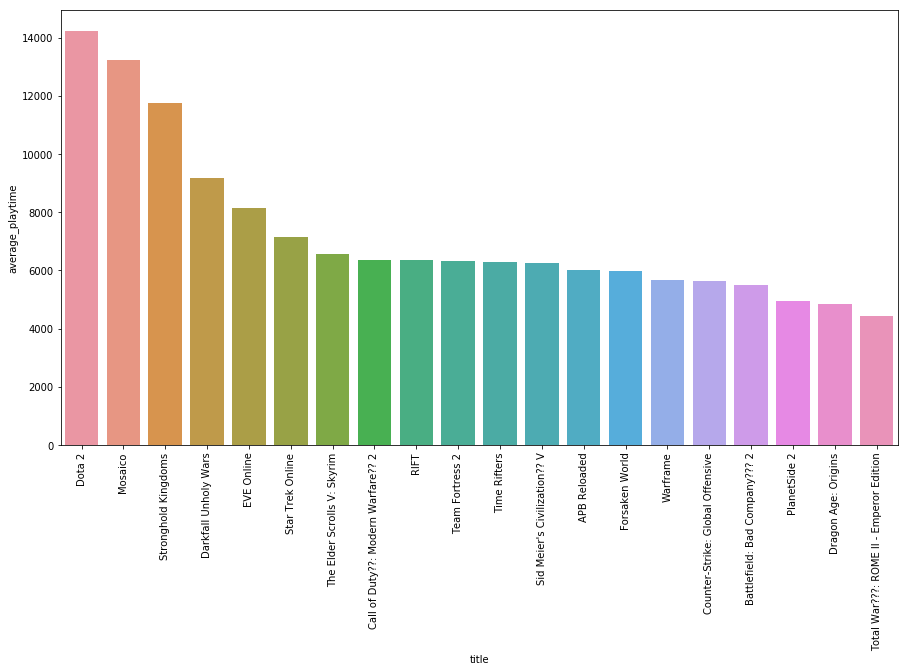

In [36]:
plt.figure(figsize=(15,8))
chart = sns.barplot(top20_addicted_games.title, top20_addicted_games.average_playtime)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

### 3. top games by revenue: which Game earned the most (5):  player_final

In [37]:
revenue_game = player_app_cluster.groupBy('app_id','title').agg(F.sum('price').alias('total_revenue')).orderBy('total_revenue', ascending = False).limit(20).toPandas()
revenue_game

,app_id,title,total_revenue
0,240,Counter-Strike: Source,4.110856e+07
1,10,Counter-Strike,2.228284e+07
2,220,Half-Life 2,1.950998e+07
3,70,Half-Life,1.910790e+07
4,550,Left 4 Dead 2,1.129535e+07
5,41070,Serious Sam 3: BFE,1.084442e+07
6,320,Half-Life 2: Deathmatch,1.006562e+07
7,50,Half-Life: Opposing Force,9.468221e+06
8,130,Half-Life: Blue Shift,9.467512e+06
9,20,Team Fortress Classic,9.463949e+06


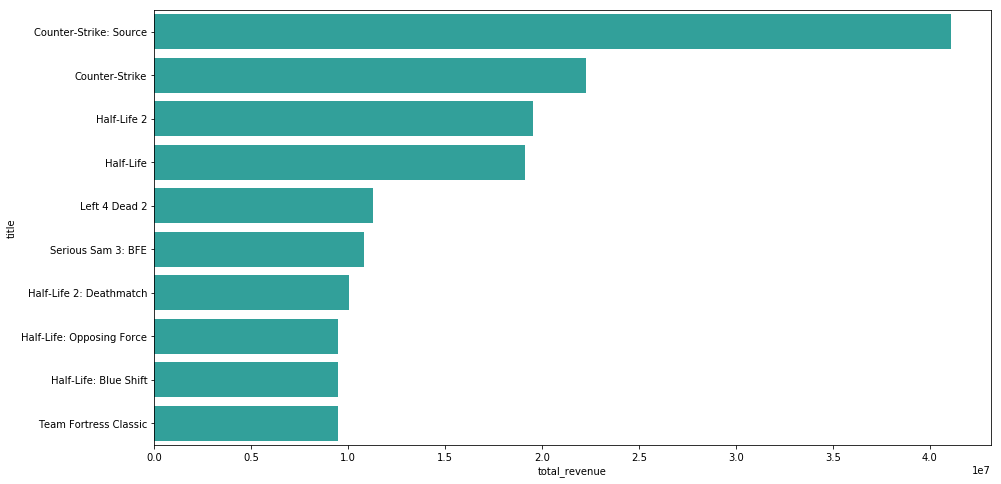

In [43]:
plt.figure(figsize=(15,8))
sns.barplot(revenue_game[:10].total_revenue, revenue_game[:10].title, color = 'lightseagreen')

In [39]:
revenue_game

,app_id,title,total_revenue
0,240,Counter-Strike: Source,4.110856e+07
1,10,Counter-Strike,2.228284e+07
2,220,Half-Life 2,1.950998e+07
3,70,Half-Life,1.910790e+07
4,550,Left 4 Dead 2,1.129535e+07
5,41070,Serious Sam 3: BFE,1.084442e+07
6,320,Half-Life 2: Deathmatch,1.006562e+07
7,50,Half-Life: Opposing Force,9.468221e+06
8,130,Half-Life: Blue Shift,9.467512e+06
9,20,Team Fortress Classic,9.463949e+06


### 4. mutli player vs single player (pie chart): player_final

In [47]:
multi_single = player_app_cluster.select('app_id', 'isMultiplayer').dropDuplicates().agg((F.sum('isMultiplayer')/count('*')*100).alias('multiplayer_pcnt')).orderBy('multiplayer_pcnt', ascending = False).limit(20).toPandas()
multi_single

,multiplayer_pcnt
0,31.14801


### 5. genre percentages: player_final

In [48]:
player_app_cluster.columns

['steam_id',
 'app_id',
 'playtime_2weeks',
 'playtime_forever',
 'dateretrieved',
 'title',
 'type',
 'price',
 'releaseDate',
 'rating',
 'ageRequirement',
 'isMultiplayer',
 'positiveReviewPercent',
 'Education',
 'Massively Multiplayer',
 'Adventure',
 'Sports',
 'Accounting',
 'Audio Production',
 'Video Production',
 'Animation & Modeling',
 'Racing',
 'Design & Illustration',
 'Software Training',
 'Photo Editing',
 'Web Publishing',
 'Utilities',
 'Early Access',
 'Casual',
 'Action',
 'Strategy',
 'Indie',
 'Free to Play',
 'RPG',
 'Simulation',
 'cluster',
 'year']

In [50]:
genre_game = player_app_cluster.select('app_id', 'Adventure',
 'Sports',
 'Racing',
 'Early Access',
 'Casual',
 'Action',
 'Strategy',
 'Indie',
 'Free to Play',
 'RPG',
 'Simulation',).dropDuplicates().toPandas()

In [51]:
genre_game.loc['total'] = genre_game.sum(axis=0)

In [53]:
genre_game

,app_id,Adventure,Sports,Racing,Early Access,Casual,Action,Strategy,Indie,Free to Play,RPG,Simulation
0,17390.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,91310.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,22370.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,209670.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4,24870.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3489,107900.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3490,265830.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3491,278810.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3492,297940.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [58]:
cols = ['app_id', 'Adventure', 'Sports', 'Racing', 'Early Access', 'Casual',
       'Action', 'Strategy', 'Indie', 'Free to Play', 'RPG', 'Simulation']

Index(['app_id', 'Adventure', 'Sports', 'Racing', 'Early Access', 'Casual',
       'Action', 'Strategy', 'Indie', 'Free to Play', 'RPG', 'Simulation'],
      dtype='object')

In [59]:
genre_game[3493:3494]

,app_id,Adventure,Sports,Racing,Early Access,Casual,Action,Strategy,Indie,Free to Play,RPG,Simulation
total,589131051.0,958.0,102.0,152.0,93.0,737.0,1537.0,834.0,1523.0,146.0,582.0,477.0


In [69]:
genre_game[3493:3494].T[1:].sort_values('total', ascending = False)

,total
Action,1537.0
Indie,1523.0
Adventure,958.0
Strategy,834.0
Casual,737.0
RPG,582.0
Simulation,477.0
Racing,152.0
Free to Play,146.0
Sports,102.0


### 6. average friend, average group & correlation between the two

In [6]:
player = spark.read.csv('/user/tamng/jwht/EDA/player_final.csv', inferSchema = True, header = True)

In [ ]:
player.limit(2).toPandas()

In [75]:
player.agg(F.avg('number_friends').alias('ave_number_friends')).show()

+------------------+
|ave_number_friends|
+------------------+
| 9.226218877983747|
+------------------+



In [76]:
player.agg(F.avg('number_groups').alias('avg_number_groups')).show()

+------------------+
| avg_number_groups|
+------------------+
|1.5977618670858234|
+------------------+



In [77]:
player.printSchema()

root
 |-- steam_id: long (nullable = true)
 |-- total_playtime_2weeks: integer (nullable = true)
 |-- total_playtime_forever: integer (nullable = true)
 |-- total_games_owned: integer (nullable = true)
 |-- total_money_spend: double (nullable = true)
 |-- total_game_multi_player: integer (nullable = true)
 |-- total_game_single_player: integer (nullable = true)
 |-- gr_education_total: double (nullable = true)
 |-- gr_mutiplayer_total: double (nullable = true)
 |-- gr_adventure_total: double (nullable = true)
 |-- gr_sports_total: double (nullable = true)
 |-- gr_accounting_total: double (nullable = true)
 |-- gr_audioProduction_total: double (nullable = true)
 |-- gr_videoProduction_total: double (nullable = true)
 |-- gr_animationModeling_total: double (nullable = true)
 |-- gr_racing_total: double (nullable = true)
 |-- gr_designIllustration_total: double (nullable = true)
 |-- gr_softwareTraining_total: double (nullable = true)
 |-- gr_photoEditing_total: double (nullable = true)
 

In [78]:
player.count()

3125641

### Correlation between groups, friends, amd money spend

In [7]:
player.stat.corr("number_friends", "number_groups")

0.508709618528312

In [12]:
player.stat.corr("number_friends", "total_money_spend")

0.2699774071265002

In [13]:
player.stat.corr("total_money_spend", "number_groups")

0.1826181362077508

In [8]:
player.stat.corr("total_playtime_forever", "total_games_owned")

0.46457442461053544

In [10]:
player.stat.corr("total_money_spend", "total_playtime_forever")

0.4934820983956463

### Correlation between money spend and number of game

In [9]:
player.stat.corr("total_money_spend", "total_games_owned")

0.9874392783801671

In [11]:
player.stat.corr("total_money_spend", "total_games_played")

0.9042666961000493

In [14]:
player.stat.corr("total_money_spend", "total_games_not_played")

0.874101303062809

### Correlation between total_games_owned and total_games_play

In [16]:
player.stat.corr("total_games_owned", "total_games_played")

0.8846456992928322

## Random split data: keep 600k rows for visulization

In [21]:
visual, delete = player.randomSplit([0.2, 0.8])

In [22]:
visual = visual.toPandas()

In [25]:
visual.shape

(625844, 37)

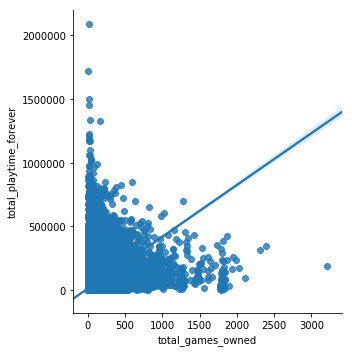

In [23]:
sns.lmplot(x="total_games_owned", y="total_playtime_forever", 
           data=visual);

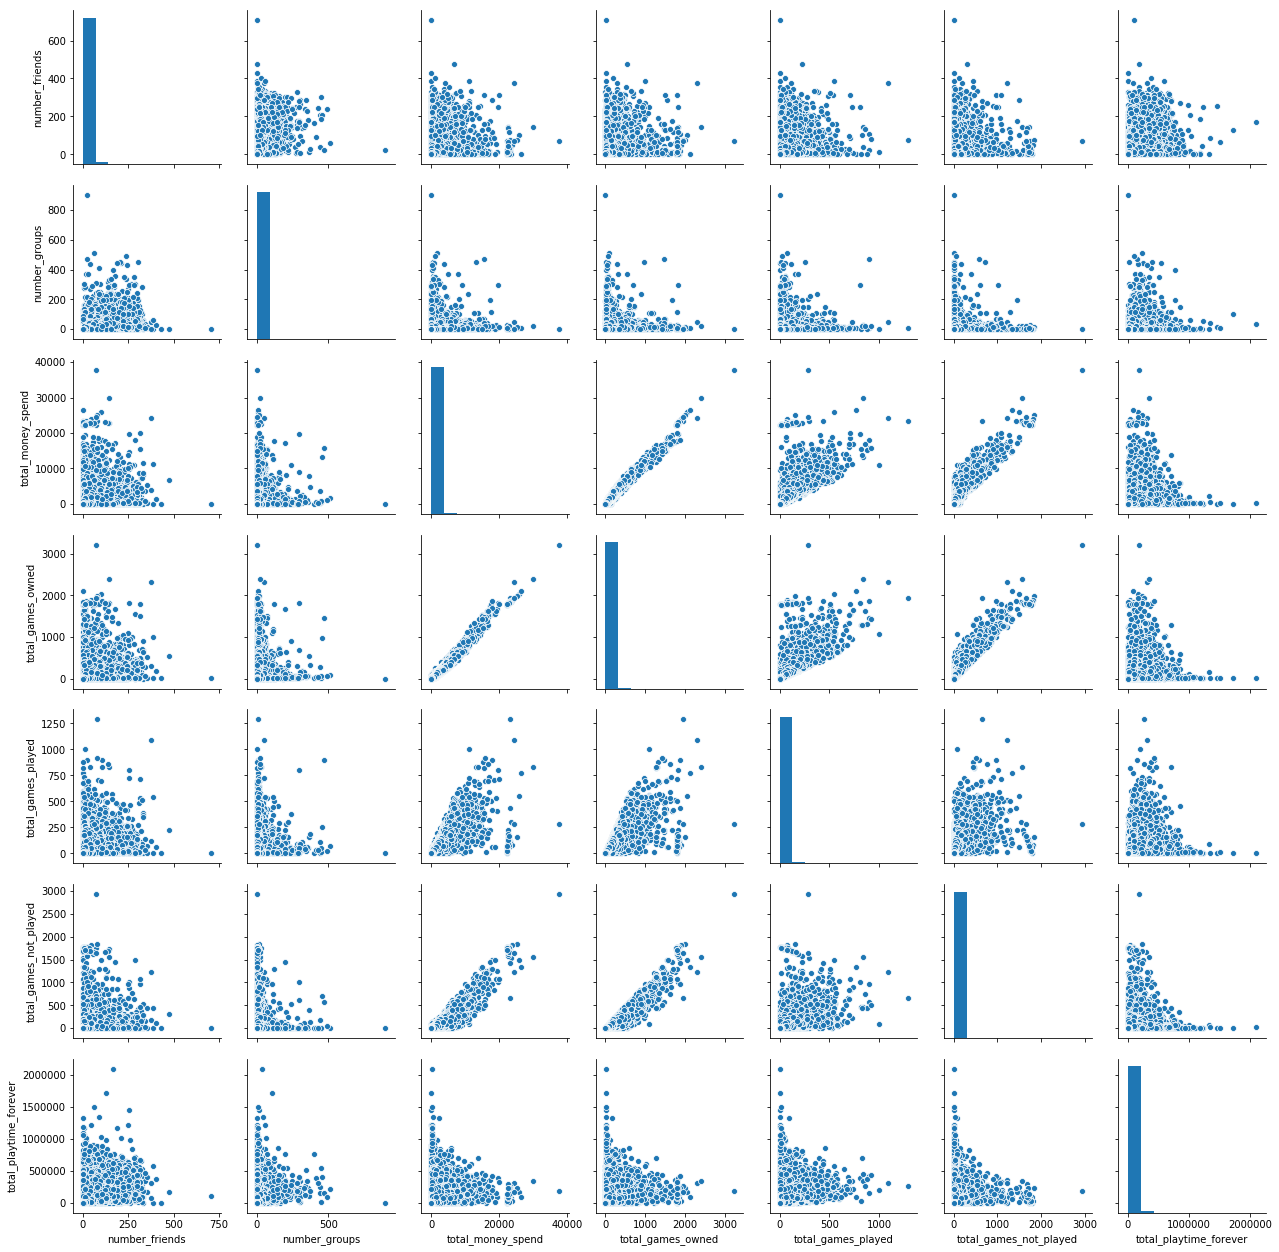

In [27]:
sns.pairplot(data=visual[['number_friends', 'number_groups', 'total_money_spend', 
                         'total_games_owned', 'total_games_played', 'total_games_not_played', 'total_playtime_forever']]);

In [60]:
def plot_heatmap(df):    
    
    ''' plot heatmap correlation''' 
    
    f, ax = plt.subplots(figsize=(12, 12))
    
    sns.heatmap(df.corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, annot = True, annot_kws={'size': 12}, ax=ax)
    plt.show()

In [55]:
cols = ['number_friends', 'number_groups', 'total_money_spend', 
                         'total_games_owned', 'total_games_played', 'total_games_not_played','total_playtime_forever']

In [37]:
visual[cols].dtypes

number_friends            int32
number_groups             int32
total_money_spend         int64
total_games_owned         int32
total_games_played        int32
total_games_not_played    int32
total_playtime_forever    int32
dtype: object

In [62]:
heatmap = visual[cols]

In [35]:
visual['total_money_spend'] = visual['total_money_spend'].astype(int)

In [49]:
heatmap.head(2)

,number_friends,number_groups,total_money_spend,total_games_owned,total_games_played,total_games_not_played,total_playtime_forever
0,13,7,270,29,12,17,5273
1,13,1,280,29,8,21,13893


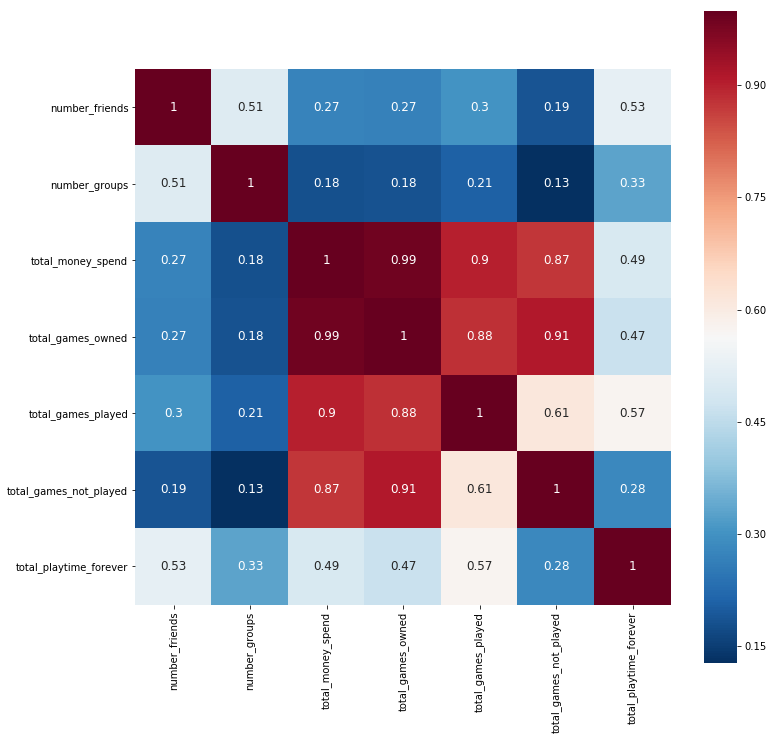

In [65]:
plt.subplots(figsize=(12, 12))
sns.heatmap(visual[cols].corr(), cmap="RdBu_r", annot = True, annot_kws={'size': 12}, square=True)

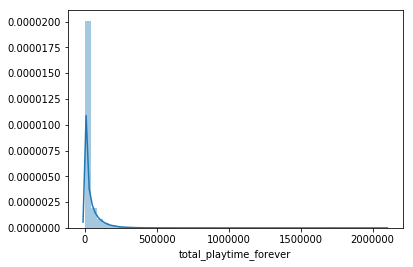

In [67]:
sns.distplot(visual.total_playtime_forever)

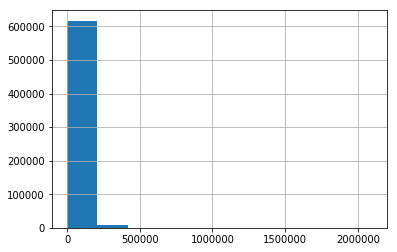

In [68]:
visual.total_playtime_forever.hist()